<a href="https://colab.research.google.com/github/jchen8000/MLDLwithPython/blob/main/4_12_Generative_Adversarial_Network/Generative_Adversarial_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generative Adversarial Networks (GANs)

A GPU is strongly recommended to run this experiment, otherwise it can be extremely slow, sometimes taking hours or even days for a single epoch. It takes near 2 hours to run 200 epochs on Google Colab with T4 GPU.

In [ ]:
%pip install \
  numpy==2.0.2 \
  scikit-learn==1.6.1 \
  matplotlib==3.10.0 \
  keras==3.10.0 \
  pydot==4.0.1

In [2]:
from datetime import datetime
from os import path
import matplotlib.pyplot as plt
import numpy as np
import pydot
import keras
from keras.datasets.mnist import load_data
from keras.models import Sequential, load_model
from keras.optimizers import Adam
from keras.layers import (
    Input,
    BatchNormalization,
    Conv2D,
    Conv2DTranspose,
    Dense,
    Dropout,
    Flatten,
    LeakyReLU,
    Reshape,
)

In [3]:
load_saved_model = False
epochs = 200
batch_size = 256
noise_shape = 100
g_file = "generator.h5"
d_file = "discriminator.h5"
gan_file = "gan.h5"

## Define Models

### Generator

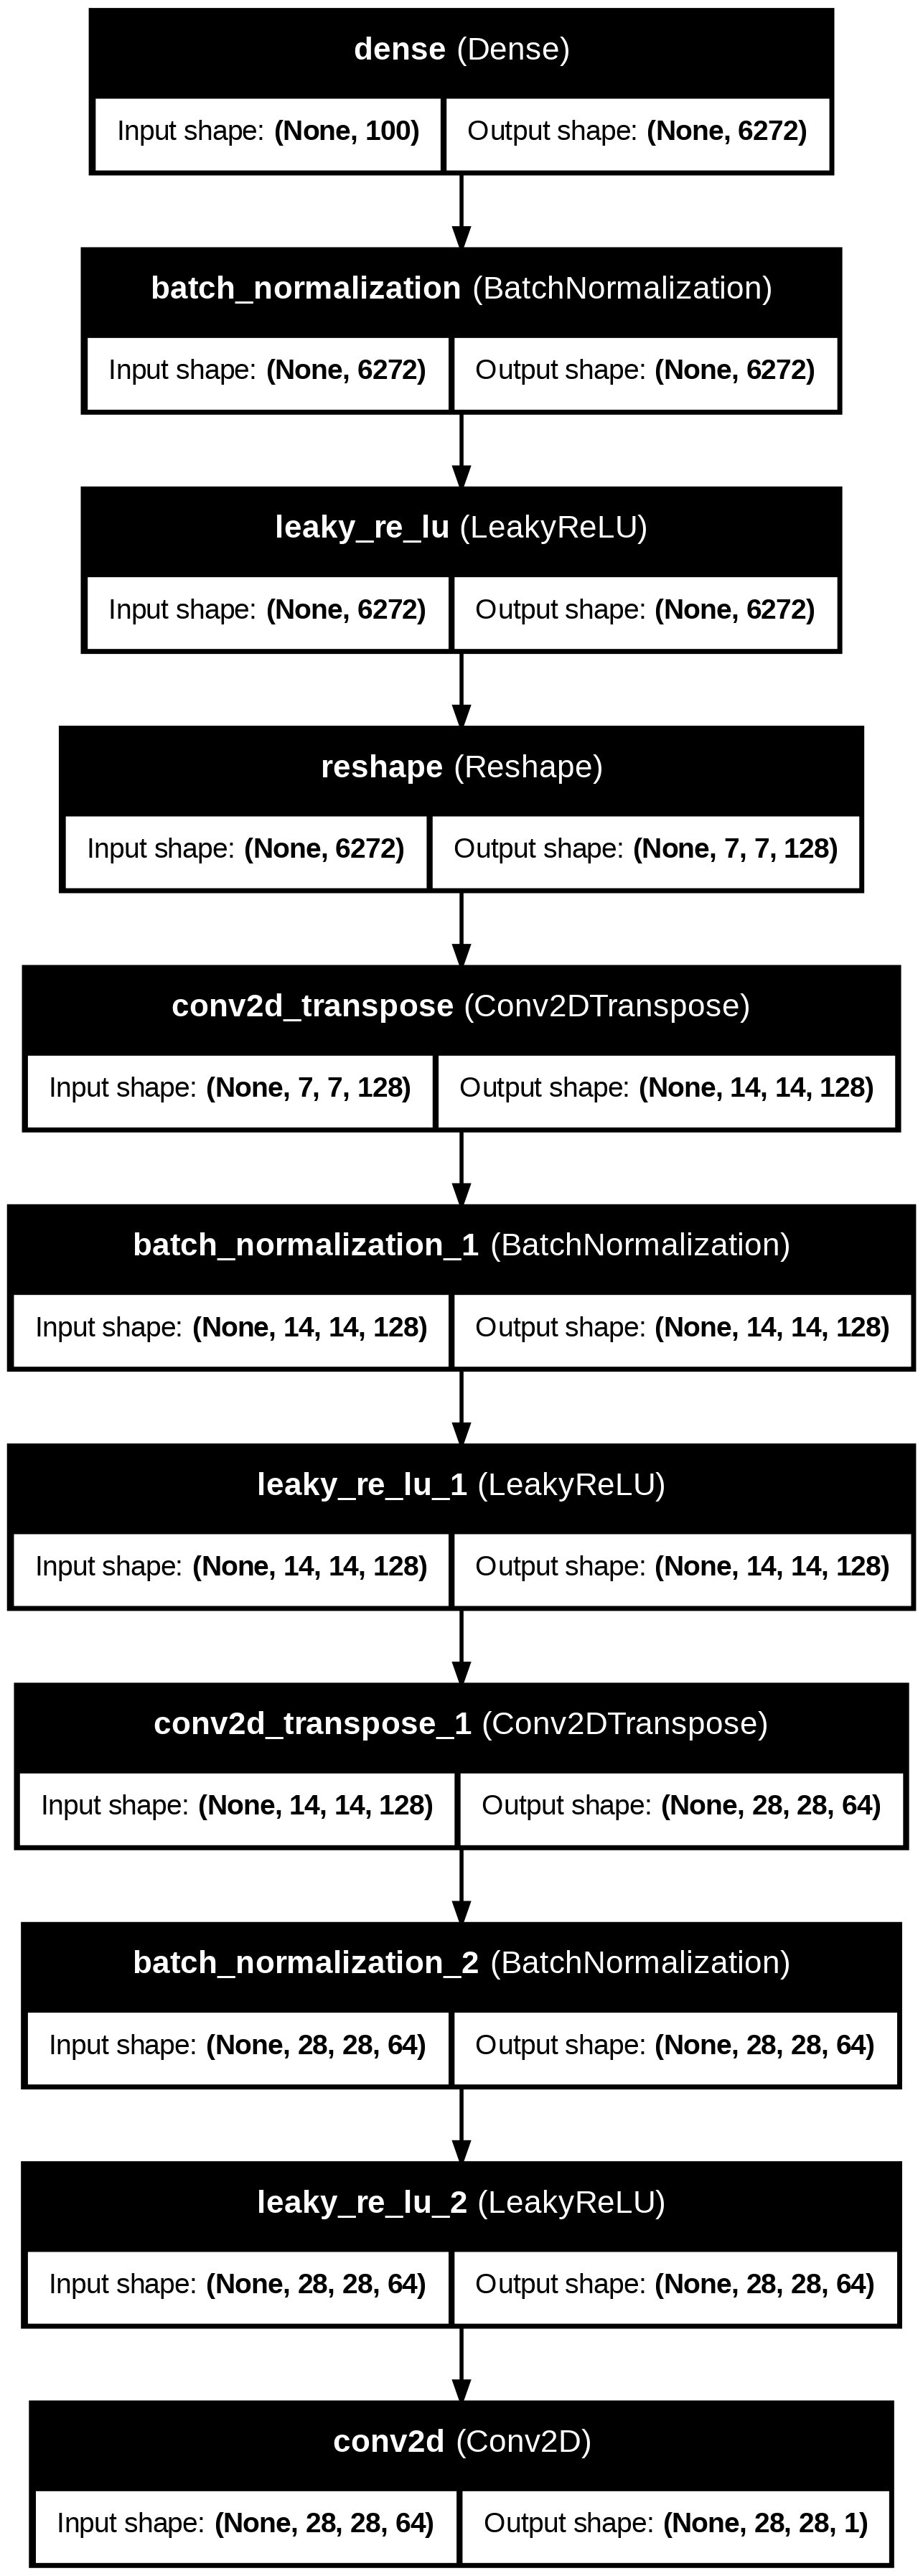

In [4]:
def generator(noise_shape):
    generator = Sequential(name="Generator")

    generator.add(Input(shape=(noise_shape,)))
    generator.add(Dense(7 * 7 * 128))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(negative_slope=0.2))
    generator.add(Reshape((7, 7, 128)))

    generator.add(Conv2DTranspose(128, (5, 5), strides=(2, 2), padding="same"))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(negative_slope=0.2))

    generator.add(Conv2DTranspose(64, (5, 5), strides=(2, 2), padding="same"))
    generator.add(BatchNormalization())
    generator.add(LeakyReLU(negative_slope=0.2))
    generator.add(Conv2D(1, (7, 7), activation="sigmoid", padding="same"))
    generator.compile(
        loss="binary_crossentropy",
        optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
        metrics=["accuracy"],
    )
    return generator

if load_saved_model and path.exists(g_file):
    g_model = load_model(g_file)
else:
    g_model = generator(noise_shape)

keras.utils.model_to_dot(g_model,show_shapes=True, show_layer_names=True).write_svg('generator.svg')
keras.utils.plot_model(g_model, show_shapes=True, show_layer_names=True)

### Discriminator

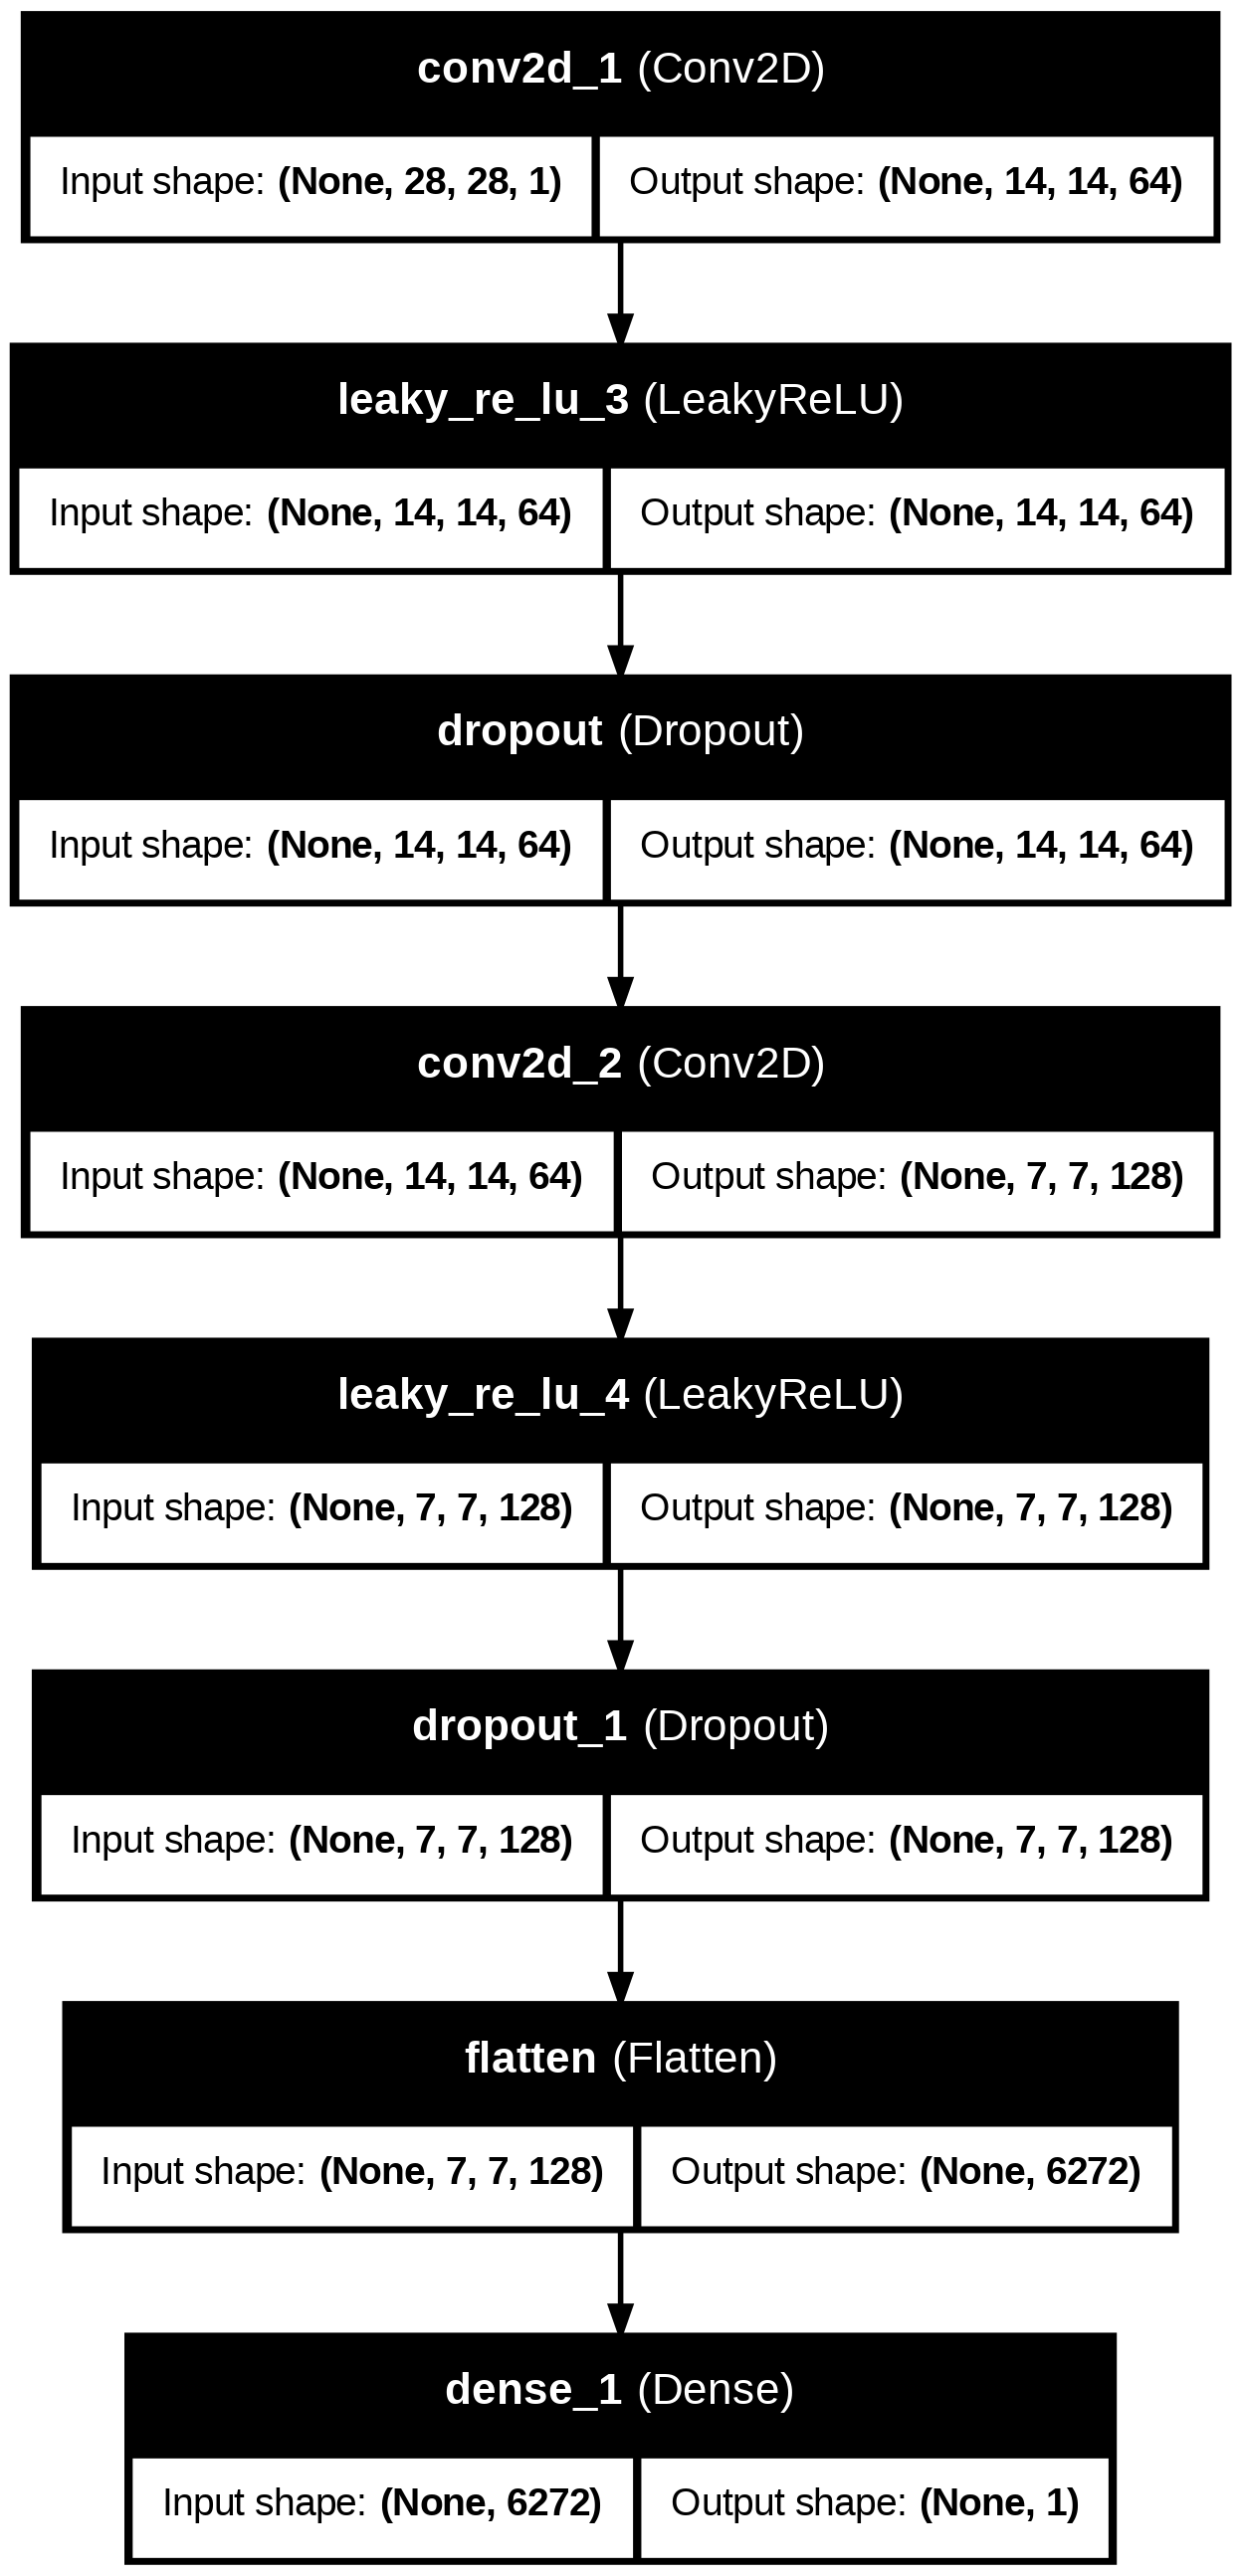

In [5]:
def discriminator(in_shape=(28, 28, 1)):
    discriminator = Sequential(name='Discriminator')

    discriminator.add(Input(shape=in_shape))
    discriminator.add(
        Conv2D(64, (5, 5), strides=(2, 2), padding="same")
    )
    discriminator.add(LeakyReLU(negative_slope=0.2))
    discriminator.add(Dropout(0.3))
    discriminator.add(Conv2D(128, (5, 5), strides=(2, 2), padding="same"))
    discriminator.add(LeakyReLU(negative_slope=0.2))
    discriminator.add(Dropout(0.3))
    discriminator.add(Flatten())
    discriminator.add(Dense(1, activation="sigmoid"))
    discriminator.compile(
        loss="binary_crossentropy",
        optimizer=Adam(learning_rate=0.0002, beta_1=0.5),
        metrics=["accuracy"],
    )
    return discriminator

if load_saved_model and path.exists(d_file):
    d_model = load_model(d_file)
else:
    d_model = discriminator()

keras.utils.model_to_dot(d_model,show_shapes=True, show_layer_names=True).write_svg('discriminator.svg')
keras.utils.plot_model(d_model,show_shapes=True, show_layer_names=True)

### GAN

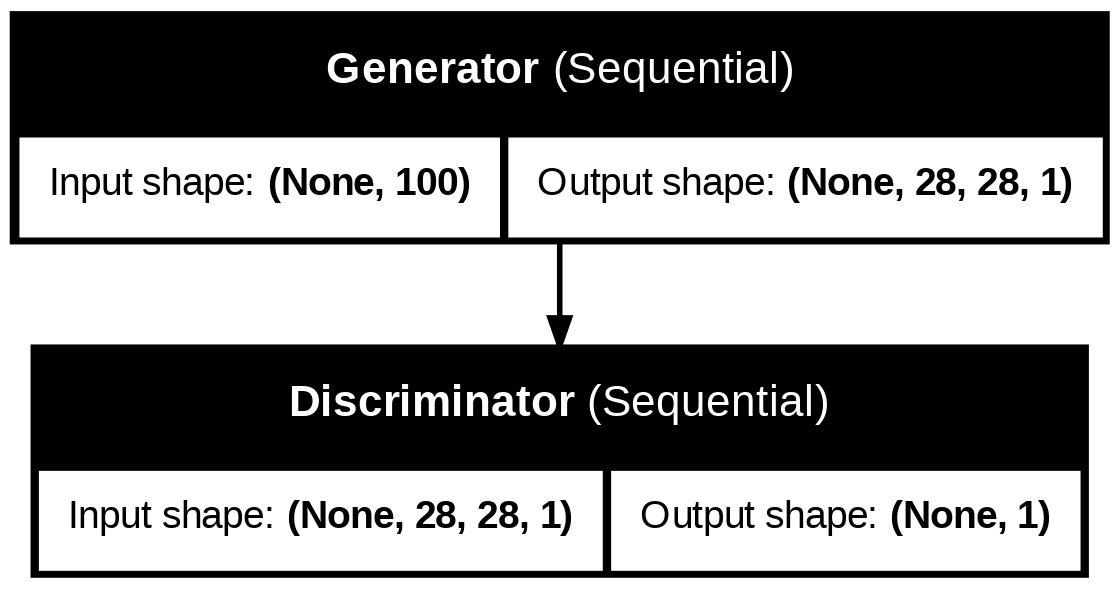

In [6]:
def gan(g_model, d_model):
    d_model.trainable = False
    model = Sequential(name='GAN')
    model.add(g_model)
    model.add(d_model)
    opt = Adam(learning_rate=0.0002, beta_1=0.5)
    model.compile(loss="binary_crossentropy", optimizer=opt)
    return model

if load_saved_model and path.exists(gan_file):
    gan_model = load_model(gan_file)
else:
    gan_model = gan(g_model, d_model)

keras.utils.model_to_dot(gan_model,show_shapes=True, show_layer_names=True).write_svg('gan_model.svg')
keras.utils.plot_model(gan_model, show_shapes=True, show_layer_names=True)


### Other Functions

In [7]:
def make_real_data(dataset, n_samples):
    idx = np.random.randint(0, dataset.shape[0], n_samples)
    X = dataset[idx]
    y = np.ones((n_samples, 1))
    return X, y

def make_noices(noise_shape, n_samples):
    noices = np.random.randn(noise_shape * n_samples)
    return noices.reshape(n_samples, noise_shape)

def make_fake_data(g_model, noise_shape, n_samples):
    noices = make_noices(noise_shape, n_samples)
    X = g_model.predict(noices, verbose=0)
    y = np.zeros((n_samples, 1))
    return X, y

def show_sample(examples, row=5, col=5, filename=None ):
    for i in range(row * col):
        plt.subplot(row, col, 1 + i)
        plt.axis("off")
        plt.imshow(examples[i, :, :, 0], cmap="gray_r")
    if filename != None:
        plt.savefig(filename, transparent=True, bbox_inches="tight")
    plt.show()

def save_models(g_model, d_model, gan_model):
    g_model.save(g_file)
    d_model.save(d_file)
    gan_model.save(gan_file)

def evaluate(g_model):
    X_real, y_real = make_real_data(X_train, 100)
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    x_fake, y_fake = make_fake_data(g_model, noise_shape, 100)
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    return acc_real, acc_fake

## Load MNIST Dataset

In [8]:
print("Load MNIST dataset.")
(X_train, _), (_, _) = load_data()
X_train = np.expand_dims(X_train, axis=-1)
X_train = X_train.astype("float32")
X_train = X_train / 255.0
print(X_train.shape)

Load MNIST dataset.
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28, 1)


## Train the GAN model

Trainning time with GPU: about 60 minutes.

In [9]:
print("Training start for %d epochs... " % (epochs))
time_start = datetime.now()
bat_per_epo = int(X_train.shape[0] / batch_size)
half_batch = int(batch_size / 2)

for i in range(epochs):
    for j in range(bat_per_epo):
        # Prepare data
        X_real, y_real = make_real_data(X_train, half_batch)
        X_fake, y_fake = make_fake_data(g_model, noise_shape, half_batch)
        X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))

        # Train Discriminator
        d_model.trainable = True
        d_loss, _ = d_model.train_on_batch(X, y)

        # Train Generator via GAN
        d_model.trainable = False
        X_gan = make_noices(noise_shape, batch_size)
        y_gan = np.ones((batch_size, 1))
        g_loss = gan_model.train_on_batch(X_gan, y_gan)

    print("Epoch: %d, discriminator loss=%.3f, gan loss=%.3f, time elapsed %d seconds." % (i + 1, d_loss, g_loss, ((datetime.now() - time_start).total_seconds()) ))
    if (i + 1) % 10 == 0:
        print("Accuracy for real data: %.3f, Accuracy for fake data: %.3f." % evaluate(g_model) )

time_end = datetime.now()
print("Training completes for %d seconds." % ((time_end - time_start).total_seconds()))

# save models after training
save_models(g_model, d_model, gan_model)

Training start for 200 epochs... 
Epoch: 1, discriminator loss=0.060, gan loss=0.068, time elapsed 46 seconds.
Epoch: 2, discriminator loss=0.153, gan loss=0.081, time elapsed 76 seconds.
Epoch: 3, discriminator loss=0.291, gan loss=0.156, time elapsed 106 seconds.
Epoch: 4, discriminator loss=0.399, gan loss=0.287, time elapsed 136 seconds.
Epoch: 5, discriminator loss=0.458, gan loss=0.370, time elapsed 166 seconds.
Epoch: 6, discriminator loss=0.496, gan loss=0.427, time elapsed 196 seconds.
Epoch: 7, discriminator loss=0.522, gan loss=0.470, time elapsed 226 seconds.
Epoch: 8, discriminator loss=0.541, gan loss=0.502, time elapsed 256 seconds.
Epoch: 9, discriminator loss=0.556, gan loss=0.527, time elapsed 285 seconds.
Epoch: 10, discriminator loss=0.569, gan loss=0.546, time elapsed 318 seconds.
Accuracy for real data: 1.000, Accuracy for fake data: 0.010.
Epoch: 11, discriminator loss=0.688, gan loss=0.561, time elapsed 350 seconds.
Epoch: 12, discriminator loss=0.688, gan loss=

Accuracy for real data: 0.320, Accuracy for fake data: 0.840.
Training completes for 6112 seconds.


### Show the samples as training results

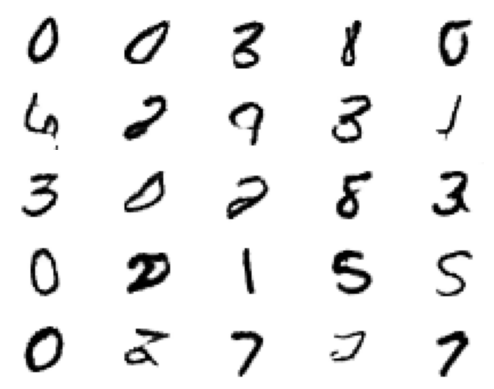

In [10]:
samples, _ = make_fake_data(g_model, noise_shape, n_samples=5*5)
show_sample(samples, row=5, col=5)

### Load trained model and display samples

Load saved models.


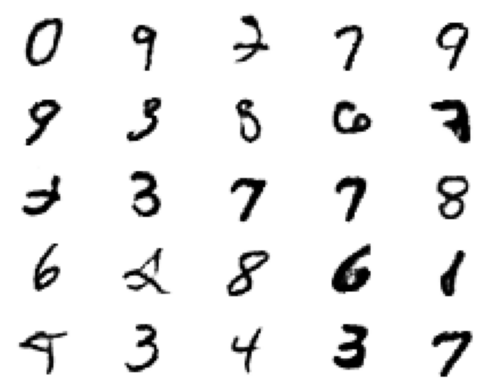

In [11]:
if path.exists(g_file):
    print("Load saved models.")
    g_model = load_model(g_file)
    samples, _ = make_fake_data(g_model, 100, n_samples=5*5)
    show_sample(samples, row=5, col=5, filename='gan.svg')